# most safe and Unsafe state in united states based on rate of homicide 
### Combined homicide data with population data for each state 

In [10]:
import os
from os import listdir
from os.path import isfile, join
import glob
import string
import operator
import csv
import pandas as pd
import calendar
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon

In [11]:
homedir = os.path.expanduser("~")
path_to_data = homedir+"\\Final\\Data"
print(path_to_data)

C:\Users\priya\Final\Data


- reading the data main homicide data and second population data 

In [12]:
for subdir,dirs, files in os.walk(path_to_data):
    #print(files)
    for file in files:
        if file == 'database.csv':
            #print(file)
            csv_data1=pd.read_csv(os.path.join(subdir,file))
        if file == 'Population By State.csv':
            csv_data2=pd.read_csv(os.path.join(subdir,file))
csv_data1.head(5)

C:\Users\priya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [13]:
# getting total number of incidents in each state 
Main_df = csv_data1[(csv_data1.State != "Unknown")].groupby(['State']).size().order(ascending=False).to_frame(name = 'number of incidents').reset_index()
Main_df.head(20)

C:\Users\priya\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


,State,number of incidents
0,California,99783
1,Texas,62095
2,New York,49268
3,Florida,37164
4,Michigan,28448
5,Illinois,25871
6,Pennsylvania,24236
7,Georgia,21088
8,North Carolina,20390
9,Louisiana,19629


- Joining the state data with population data to get population for each state 

In [40]:
#merging the 2 datafrome based on state 
final_df = pd.merge(Main_df,csv_data2,on='State',how='inner')
final_df.reset_index()
final_df.head(5)

,State,number of incidents,Population
0,California,99783,39250017.0
1,Texas,62095,27862596.0
2,New York,49268,19745289.0
3,Florida,37164,20612439.0
4,Michigan,28448,9928300.0


In [54]:
#final_df = final_df.convert_objects(convert_numeric=True)
# calculating the number of homicide per capita
final_df["murder crimes per 10,000"] = (final_df["number of incidents"])/(final_df["Population"])*10000
final_df = final_df.sort(['murder crimes per 10,000'], ascending=[0])
final_df.head(55)

C:\Users\priya\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,State,number of incidents,Population,"murder crimes per 10,000"
22,District of Columbia,7115,681170.0,104.452633
9,Louisiana,19629,4681666.0,41.927382
11,Maryland,17312,6016447.0,28.774458
4,Michigan,28448,9928300.0,28.653445
0,California,99783,39250017.0,25.422409
2,New York,49268,19745289.0,24.951775
14,Missouri,14832,6093000.0,24.342688
17,South Carolina,11698,4961119.0,23.579358
19,Alabama,11376,4863300.0,23.391524
23,Arkansas,6947,2988248.0,23.247736


C:\Users\priya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


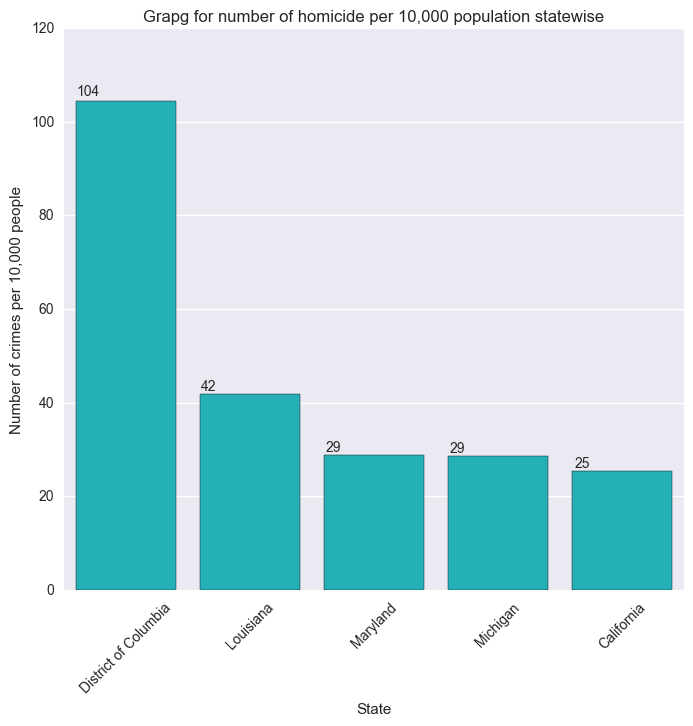

In [49]:
# plotting the grapth for result 
a4_dims = (8, 7.25)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x="State", y="murder crimes per 10,000", data=final_df.head(5),color="#0DC5CF")
ax.set_xticklabels(final_df["State"], rotation=45)
ax.set_ylabel('Number of crimes per 10,000 people')
ax.set_xlabel('State')
ax.set_title('Grapg for number of homicide per 10,000 population statewise')

for ax in fig.axes:
    for p in ax.patches:
        ax.annotate(str(round(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005), ha='left', va='bottom')

plt.savefig('Output_Files\\Analysis 3\\png\\result.png', bbox_inches='tight')

In [44]:
new_Final_df = final_df.copy(deep=True)
new_Final_df= new_Final_df.sort(['murder crimes per 10,000'], ascending=[1])
new_Final_df.head()

C:\Users\priya\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,State,number of incidents,Population,"murder crimes per 10,000"
50,North Dakota,308,757952.0,4.063582
45,New Hampshire,655,1334795.0,4.907121
48,South Dakota,442,865454.0,5.107146
37,Iowa,1749,3134693.0,5.579494
47,Montana,601,1042520.0,5.764877


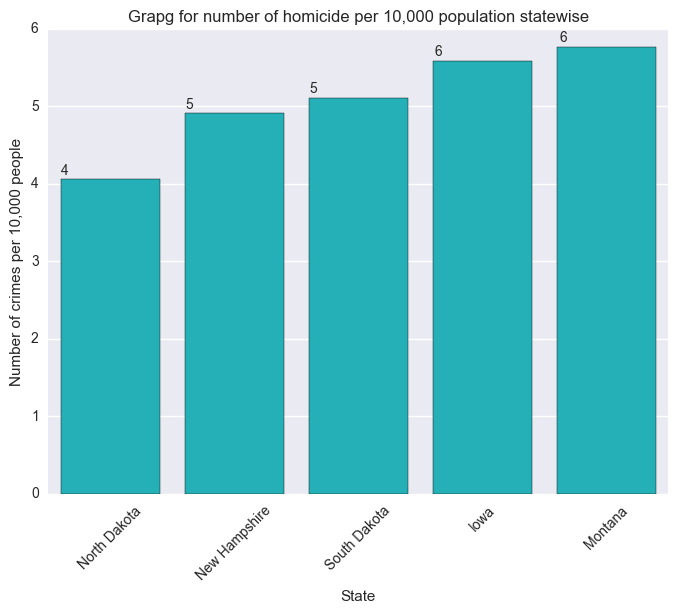

In [53]:
a4_dims = (8, 6)
fig1, ax1 = plt.subplots(figsize=a4_dims)
ax1 = sns.barplot(x="State", y="murder crimes per 10,000", data=new_Final_df.head(5),color="#0DC5CF")
ax1.set_xticklabels(new_Final_df["State"], rotation=45)
ax1.set_ylabel('Number of crimes per 10,000 people')
ax1.set_xlabel('State')
ax1.set_title('Grapg for number of homicide per 10,000 population statewise')

for ax in fig1.axes:
    for p in ax.patches:
        ax.annotate(str(round(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005), ha='left', va='bottom')

plt.savefig('Output_Files\\Analysis 3\\png\\result_safe.png', bbox_inches='tight')

In [55]:
states = ['New Jersey','Rhode Island','Massachusetts','Connecticut','Maryland','New York','Delaware','Florida','Ohio','Pennsylvania', 'Illinois',
'California','Hawaii','Virginia','Michigan','Indiana','North Carolina','Georgia','Tennessee',
'New Hampshire','South Carolina','Louisiana','Kentucky','Wisconsin','Washington','Alabama','Missouri','Texas',
'West Virginia','Vermont','Minnesota','Mississippi','Iowa','Arkansas','Oklahoma','Arizona','Colorado','Maine','Oregon',
'Kansas','Utah','Nebraska','Nevada','Idaho','New Mexico','South Dakota','North Dakota','Montana','Wyoming','Alaska'
]
statesPop2015 = final_df['State'].values
statesPop2015Total = final_df['murder crimes per 10,000'].values
popDict = {}
for each in states:
    if each not in statesPop2015:
        popDict[each] = 0.0
    else:
        for i,j in zip(statesPop2015,statesPop2015Total):
             popDict[i] = j

C:\Users\priya\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in sqrt
C:\Users\priya\Anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


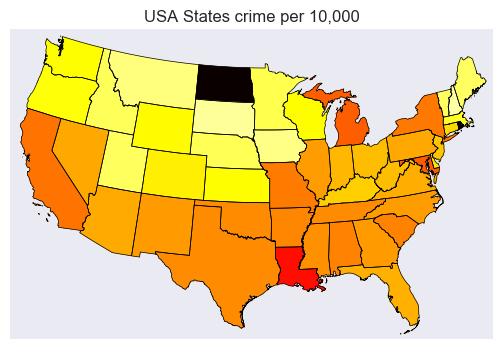

In [72]:
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)
# population density by state from
# http://en.wikipedia.org/wiki/List_of_U.S._states_by_population_density
# choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.hot # use 'hot' colormap
vmin = 4.063582; vmax = 104.452633 # set range.
for shapedict in m.states_info:
    #print(shapedict)
    statename = shapedict['NAME']
    #print(statename)
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = popDict[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
# cycle through state names, color each one.
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        #print('entering')
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
plt.title('USA States crime per 10,000')
a=(11.7,8.25)
plt.savefig('Output_Files\\Analysis 3\\png\\USA States crime per 10,000.png', bbox_inches='tight')
plt.show()

In [24]:
def save_to_csv():
    if not os.path.exists(homedir+"\\Final\\Output_Files\\Analysis 3\\CSV"):
        os.makedirs(homedir+"\\Final\\Output_Files\\Analysis 3\\CSV")
    with open(homedir+"\\Final\\Output_Files\\Analysis 3\\CSV\\Analysis_3_ouptput.csv", 'w') as myfile:
        myfile.write(final_df.to_csv(index=False))

In [25]:
save_to_csv()

# Conclusion

- Two of most unsafe states where crime rates are high are D.C. and Louisiana
- North Dakota and New Hampshire are the 2 safe states according to crime rate 
- The FBI's crime report for 2012 found nearly 68% of all homicides in America involved a firearm, and Louisiana fiercely protects the right to bear arms. The state passed an amendment in November making gun ownership a "fundamental right" like free speech and making it extremely difficult to pass laws that step on that right.Louisiana also passed a law recently that lets its citizens apply for concealed carry handgun permits that last their entire lifetimes. Louisianans who want to walk around and openly carry their guns don't need a permit at all under the state's open carry law.